## Buat Spark Session dan Load Data dari HDFS

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, LongType

spark = SparkSession.builder \
    .appName("ETL Hasil Laut") \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()


# Path HDFS yang lebih eksplisit
path_hdfs = "hdfs://localhost:9000/dataset/data1.csv"

# Nama kolom (jika diperlukan, misalnya jika tidak ada header atau untuk skema manual)
nama_kolom = ["tahun", "kabupaten_kota", "wpp", "volume_produksi_ton", "nilai_produksi_rp_000", "provinsi", "kelompok", "jenis_ikan"]

try:
    df_hdfs = spark.read.format("csv") \
        .option("header", "true") \
        .option("delimiter", ",") \
        .option("inferSchema", "true") \
        .load(path_hdfs)

    print(f"Berhasil membaca dari HDFS: {path_hdfs}")
    df_hdfs.printSchema()
    df_hdfs.show(5, truncate=False)
    print(f"Jumlah baris yang dibaca dari HDFS: {df_hdfs.count()}")

except Exception as e:
    print(f"Error membaca file dari HDFS {path_hdfs}: {e}")
    print("Pastikan URI HDFS benar dan NameNode berjalan.")
    print("Pastikan file ada di path tersebut dan Spark memiliki izin akses.")
    print("Periksa format file dan opsi yang digunakan.")

finally:
    # Hentikan SparkSession
    print("Done")

25/05/27 15:43:20 WARN Utils: Your hostname, localhost resolves to a loopback address: 127.0.0.1; using 172.17.0.2 instead (on interface eth0)
25/05/27 15:43:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/27 15:43:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

Berhasil membaca dari HDFS: hdfs://localhost:9000/dataset/data1.csv
root
 |-- Tahun: integer (nullable = true)
 |-- Kabupaten/Kota: string (nullable = true)
 |-- WPP: string (nullable = true)
 |-- Volume Produksi (Ton): double (nullable = true)
 |-- Nilai Produksi (Rp 000): integer (nullable = true)
 |-- Provinsi: string (nullable = true)
 |-- Kelompok: string (nullable = true)
 |-- Jenis Ikan;: string (nullable = true)

+-----+--------------+----------+---------------------+-----------------------+--------------+-----------+-----------------------------+
|Tahun|Kabupaten/Kota|WPP       |Volume Produksi (Ton)|Nilai Produksi (Rp 000)|Provinsi      |Kelompok   |Jenis Ikan;                  |
+-----+--------------+----------+---------------------+-----------------------+--------------+-----------+-----------------------------+
|2023 |AGAM          |WPP-RI-572|184.17               |3683400                |SUMATERA BARAT|ALU-ALU    |ALU-ALU BESAR; BARAKUDA BESAR|
|2023 |AGAM          |WPP-R

## Eksplorasi Data

In [8]:
from pyspark.sql.functions import col, countDistinct, avg, min, max, round

# Menampilkan jumlah total baris
print(f"Jumlah total baris: {df_hdfs.count()}")

# Menampilkan jumlah nilai unik dalam setiap kolom
df_hdfs.select([countDistinct(col(c)).alias(f"Unique_{c}") for c in df_hdfs.columns]).show()

# Menampilkan statistik deskriptif untuk kolom numerik
df_hdfs.describe().show()

Jumlah total baris: 8144
+------------+---------------------+----------+----------------------------+------------------------------+---------------+---------------+------------------+
|Unique_Tahun|Unique_Kabupaten/Kota|Unique_WPP|Unique_Volume Produksi (Ton)|Unique_Nilai Produksi (Rp 000)|Unique_Provinsi|Unique_Kelompok|Unique_Jenis Ikan;|
+------------+---------------------+----------+----------------------------+------------------------------+---------------+---------------+------------------+
|           5|                   45|         7|                        6918|                          7835|              6|             98|               344|
+------------+---------------------+----------+----------------------------+------------------------------+---------------+---------------+------------------+



25/05/27 15:43:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 15:>                                                         (0 + 1) / 1]

+-------+------------------+--------------+--------------------+---------------------+-----------------------+--------------+--------+------------+
|summary|             Tahun|Kabupaten/Kota|                 WPP|Volume Produksi (Ton)|Nilai Produksi (Rp 000)|      Provinsi|Kelompok| Jenis Ikan;|
+-------+------------------+--------------+--------------------+---------------------+-----------------------+--------------+--------+------------+
|  count|              8144|          8144|                8144|                 8144|                   8144|          8144|    8144|        8144|
|   mean|2020.9964390962673|          NULL|                NULL|    604.7076743614933|   1.8392105080427308E7|          NULL|    NULL|        NULL|
| stddev| 1.424893020401632|          NULL|                NULL|    1656.932747495079|    4.427455021285158E7|          NULL|    NULL|        NULL|
|    min|              2019|          AGAM|Laut Lepas Samude...|                  0.0|                     15|  

## Preprocessing Data

In [9]:
df_hdfs.show()

+-----+--------------+----------+---------------------+-----------------------+--------------+-----------+--------------------+
|Tahun|Kabupaten/Kota|       WPP|Volume Produksi (Ton)|Nilai Produksi (Rp 000)|      Provinsi|   Kelompok|         Jenis Ikan;|
+-----+--------------+----------+---------------------+-----------------------+--------------+-----------+--------------------+
| 2023|          AGAM|WPP-RI-572|               184.17|                3683400|SUMATERA BARAT|    ALU-ALU|ALU-ALU BESAR; BA...|
| 2023|          AGAM|WPP-RI-572|               364.68|               12763660|SUMATERA BARAT|      BAWAL|        BAWAL HITAM;|
| 2023|          AGAM|WPP-RI-572|                16.99|                 509640|SUMATERA BARAT|    BELANAK|            BELANAK;|
| 2023|          AGAM|WPP-RI-572|               134.91|                2698280|SUMATERA BARAT|BIJI NANGKA| BIJI NANGKA KARANG;|
| 2023|          AGAM|WPP-RI-572|               457.54|                8235702|SUMATERA BARAT|BIJI NANGK

In [10]:
from pyspark.sql.functions import col, trim
from pyspark.sql.types import IntegerType, DoubleType, LongType

# Rename kolom agar mudah digunakan
df_clean = df_hdfs.select(
    col("Tahun").alias("tahun"),
    col("Kabupaten/Kota").alias("kabupaten_kota"),
    col("WPP").alias("wpp"),
    col("Volume Produksi (Ton)").alias("volume_produksi_ton"),
    col("Nilai Produksi (Rp 000)").alias("nilai_produksi_rp000"),
    col("Provinsi").alias("provinsi"),
    col("Kelompok").alias("kelompok"),
    col("Jenis Ikan;").alias("jenis_ikan")
)

# Trim whitespace di kolom string
string_cols = ["kabupaten_kota", "wpp", "provinsi", "kelompok", "jenis_ikan"]
for col_name in string_cols:
    df_clean = df_clean.withColumn(col_name, trim(col(col_name)))

# Konversi tipe data
df_clean = df_clean \
    .withColumn("tahun", col("tahun").cast(IntegerType())) \
    .withColumn("volume_produksi_ton", col("volume_produksi_ton").cast(DoubleType())) \
    .withColumn("nilai_produksi_rp000", col("nilai_produksi_rp000").cast(LongType()))

# Drop duplikat dan null penting
df_clean = df_clean.dropDuplicates()
df_clean = df_clean.dropna(subset=["tahun", "kabupaten_kota", "jenis_ikan"])


In [11]:
output_path = "hdfs://localhost:9000/dataset/hasil_laut_clean"

df_clean.write.mode("overwrite").parquet(output_path)


In [12]:
output_path = "hdfs://localhost:9000/dataset/hasil_laut_per_tahun"

df_clean.write \
    .partitionBy("tahun") \
    .mode("overwrite") \
    .parquet(output_path)


In [13]:
df_clean.show(5)

+-----+-------------------+----------+-------------------+--------------------+--------------+--------+--------------------+
|tahun|     kabupaten_kota|       wpp|volume_produksi_ton|nilai_produksi_rp000|      provinsi|kelompok|          jenis_ikan|
+-----+-------------------+----------+-------------------+--------------------+--------------+--------+--------------------+
| 2023|    INDRAGIRI HILIR|WPP-RI-711|            5689.93|            56899310|          RIAU|  BELOSO| ACANG-ACANG BOMBAY;|
| 2023|KOTA BANDAR LAMPUNG|WPP-RI-572|              93.25|             5217565|       LAMPUNG| TONGKOL|    TONGKOL ABU-ABU;|
| 2023|       KOTA SIBOLGA|WPP-RI-572|               15.7|              706500|SUMATERA UTARA| ALU-ALU|ALU-ALU BESAR; BA...|
| 2023|       KOTA SIBOLGA|WPP-RI-572|               1.09|               27250|SUMATERA UTARA|   SELAR|        SELAR HIJAU;|
| 2023|    LAMPUNG SELATAN|WPP-RI-572|             798.36|            18875706|       LAMPUNG| PEPEREK|   PEPEREK BONDOLAN;|


## Klastering

In [14]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# 1. Inisiasi SparkSession
spark = SparkSession.builder.appName("ClusteringHasilLaut2023").getOrCreate()

# 2. Load data parquet khusus tahun 2023
data_path = "hdfs://localhost:9000/dataset/hasil_laut_per_tahun/tahun=2023"  # path hasil partitionBy
df_2023 = spark.read.parquet(data_path)

# 3. Pilih fitur numerik yang relevan untuk clustering
features = ["volume_produksi_ton"]

# 4. Buat vector assembler (gabung fitur ke vector)
assembler = VectorAssembler(inputCols=features, outputCol="features_vector")

# 5. Normalisasi fitur (optional tapi direkomendasikan)
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features")

# 6. Definisikan model KMeans (misal cluster=3)
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=3, seed=42)

# 7. Pipeline (assembler -> scaler -> kmeans)
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# 8. Latih model cluster
model = pipeline.fit(df_2023)

# 9. Prediksi cluster
result = model.transform(df_2023)

# 10. Tampilkan hasil cluster + beberapa kolom
result.select("kabupaten_kota", "volume_produksi_ton", "nilai_produksi_rp000", "cluster").show(20, truncate=False)


25/05/27 15:43:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/05/27 15:43:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+-------------------+-------------------+--------------------+-------+
|kabupaten_kota     |volume_produksi_ton|nilai_produksi_rp000|cluster|
+-------------------+-------------------+--------------------+-------+
|INDRAGIRI HILIR    |5689.93            |56899310            |2      |
|KOTA BANDAR LAMPUNG|93.25              |5217565             |0      |
|KOTA SIBOLGA       |15.7               |706500              |0      |
|KOTA SIBOLGA       |1.09               |27250               |0      |
|LAMPUNG SELATAN    |798.36             |18875706            |0      |
|LAMPUNG TIMUR      |26.23              |1076275             |0      |
|NIAS SELATAN       |830.49             |17635572            |0      |
|TAPANULI TENGAH    |2102.9             |52572500            |2      |
|BANYUASIN          |3347.82            |284564530           |2      |
|BATU BARA          |2889.55            |115581920           |2      |
|BENGKALIS          |42.54              |2764775             |0      |
|DELI 

In [15]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Gunakan fitur scaled yang sudah dibuat di pipeline, misal scaled_features

# Ambil hasil prediksi cluster
predictions = model.transform(df_2023)

# Evaluator menggunakan metrik Silhouette (default memakai cosine atau squared euclidean)
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score untuk model KMeans: {silhouette_score}")


Silhouette Score untuk model KMeans: 0.9136527321989927


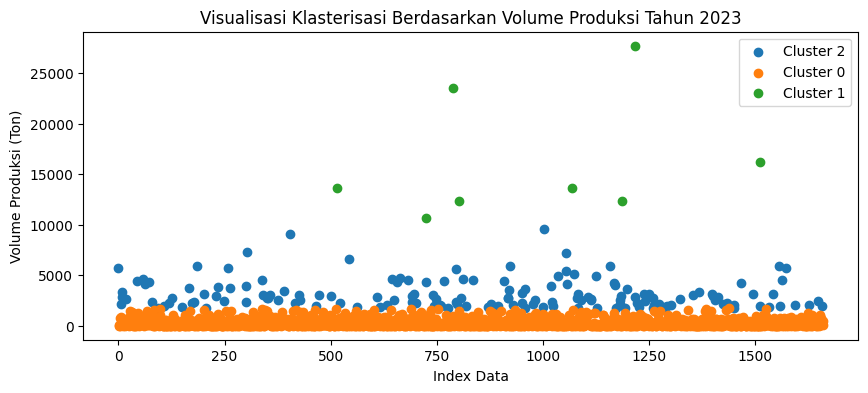

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Ambil hasil klaster dan volume produksi
result_pd = result.select("volume_produksi_ton", "cluster").toPandas()

# Scatter plot satu dimensi hasil klasterisasi
plt.figure(figsize=(10, 4))
for cluster_id in result_pd['cluster'].unique():
    subset = result_pd[result_pd['cluster'] == cluster_id]
    plt.scatter(subset.index, subset['volume_produksi_ton'], label=f'Cluster {cluster_id}')

plt.title('Visualisasi Klasterisasi Berdasarkan Volume Produksi Tahun 2023')
plt.xlabel('Index Data')
plt.ylabel('Volume Produksi (Ton)')
plt.legend()
plt.show()


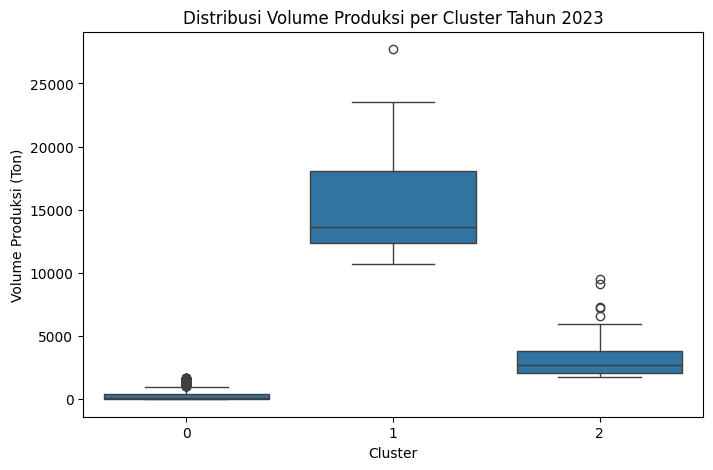

In [17]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x='cluster', y='volume_produksi_ton', data=result_pd)
plt.title('Distribusi Volume Produksi per Cluster Tahun 2023')
plt.xlabel('Cluster')
plt.ylabel('Volume Produksi (Ton)')
plt.show()


In [18]:
# Hitung jumlah nilai unik kabupaten/kota
unique_count = result.select("kabupaten_kota").distinct().count()
print(f"Jumlah kabupaten/kota unik: {unique_count}")

# Tampilkan daftar kabupaten/kota unik
unique_kabupaten = result.select("kabupaten_kota").distinct().collect()
unique_kabupaten_list = [row['kabupaten_kota'] for row in unique_kabupaten]
print("Daftar kabupaten/kota unik:")
for kab in unique_kabupaten_list:
    print(kab)


Jumlah kabupaten/kota unik: 45
Daftar kabupaten/kota unik:
KOTA SIBOLGA
KOTA PADANG
KEPULAUAN MERANTI
LAMPUNG TIMUR
KOTA BANDAR LAMPUNG
SERDANG BEDAGAI
PASAMAN BARAT
TANJUNG JABUNG TIMUR
TANGGAMUS
KEPULAUAN MENTAWAI
TULANG BAWANG
TAPANULI SELATAN
LABUHANBATU
LABUHANBATU UTARA
BENGKALIS
KOTA DUMAI
BATU BARA
KOTA GUNUNGSITOLI
INDRAGIRI HILIR
LAMPUNG SELATAN
LANGKAT
SIAK
NIAS SELATAN
KOTA TANJUNG BALAI
ASAHAN
PESISIR BARAT
MESUJI
PESISIR SELATAN
PADANG PARIAMAN
OGAN KOMERING ILIR
PELALAWAN
DELI SERDANG
TAPANULI TENGAH
MANDAILING NATAL
PESAWARAN
BANYUASIN
KOTA MEDAN
NIAS BARAT
ROKAN HILIR
KOTA PARIAMAN
TANJUNG JABUNG BARAT
NIAS UTARA
LAMPUNG TENGAH
AGAM
NIAS


In [19]:
import json

# Buka file JSON lokal
with open("/home/ubuntu/regencies.json", "r") as f:
    data = json.load(f)

# Contoh looping tiap item di JSON
for item in data:
    nama_kabupaten = item.get("name")
    latitude = item.get("latitude")
    longitude = item.get("longitude")
    
    print(f"Nama Kabupaten: {nama_kabupaten}, Latitude: {latitude}, Longitude: {longitude}")


Nama Kabupaten: KABUPATEN SIMEULUE, Latitude: 2.61667, Longitude: 96.08333
Nama Kabupaten: KABUPATEN ACEH SINGKIL, Latitude: 2.41667, Longitude: 97.91667
Nama Kabupaten: KABUPATEN ACEH SELATAN, Latitude: 3.16667, Longitude: 97.41667
Nama Kabupaten: KABUPATEN ACEH TENGGARA, Latitude: 3.36667, Longitude: 97.7
Nama Kabupaten: KABUPATEN ACEH TIMUR, Latitude: 4.63333, Longitude: 97.63333
Nama Kabupaten: KABUPATEN ACEH TENGAH, Latitude: 4.51, Longitude: 96.855
Nama Kabupaten: KABUPATEN ACEH BARAT, Latitude: 4.45, Longitude: 96.16667
Nama Kabupaten: KABUPATEN ACEH BESAR, Latitude: 5.38333, Longitude: 95.51667
Nama Kabupaten: KABUPATEN PIDIE, Latitude: 5.08, Longitude: 96.11
Nama Kabupaten: KABUPATEN BIREUEN, Latitude: 5.08333, Longitude: 96.58333
Nama Kabupaten: KABUPATEN ACEH UTARA, Latitude: 4.97, Longitude: 97.14
Nama Kabupaten: KABUPATEN ACEH BARAT DAYA, Latitude: 3.83333, Longitude: 96.88333
Nama Kabupaten: KABUPATEN GAYO LUES, Latitude: 3.95, Longitude: 97.39
Nama Kabupaten: KABUPATEN A

In [20]:
import pandas as pd

df_reg = pd.DataFrame(data)

# Tampilkan DataFrame
print(df_reg.head())

     id province_id                     name                 alt_name  \
0  1101          11       KABUPATEN SIMEULUE       KABUPATEN SIMEULUE   
1  1102          11   KABUPATEN ACEH SINGKIL   KABUPATEN ACEH SINGKIL   
2  1103          11   KABUPATEN ACEH SELATAN   KABUPATEN ACEH SELATAN   
3  1104          11  KABUPATEN ACEH TENGGARA  KABUPATEN ACEH TENGGARA   
4  1105          11     KABUPATEN ACEH TIMUR     KABUPATEN ACEH TIMUR   

   latitude  longitude  
0   2.61667   96.08333  
1   2.41667   97.91667  
2   3.16667   97.41667  
3   3.36667   97.70000  
4   4.63333   97.63333  


In [29]:
from thefuzz import process

# Misal df['name'] adalah list nama kabupaten dari JSON
list_json_names = df_reg['name'].tolist()

hasil_mapping = {}

for kab in unique_kabupaten_list:
    # Cari nama paling mirip dari list_json_names untuk kab
    best_match, score = process.extractOne(kab, list_json_names)
    # Kamu bisa atur threshold score supaya yang terlalu beda ga dianggap cocok
    if score >= 70:
        # Ambil lat-long dari df yang cocok
        latlong_row = df_reg[df_reg['name'] == best_match][['latitude', 'longitude']].iloc[0]
        hasil_mapping[kab] = (latlong_row['latitude'], latlong_row['longitude'])
    else:
        hasil_mapping[kab] = (None, None)

# Tampilkan hasil
for kab, coords in hasil_mapping.items():
    print(f"{kab}: Latitude = {coords[0]}, Longitude = {coords[1]}")


KOTA SIBOLGA: Latitude = 1.73333, Longitude = 98.8
KOTA PADANG: Latitude = -0.98333, Longitude = 100.45
KEPULAUAN MERANTI: Latitude = 0.97488, Longitude = 102.69539
LAMPUNG TIMUR: Latitude = -5.10273, Longitude = 105.68003
KOTA BANDAR LAMPUNG: Latitude = -5.41667, Longitude = 105.25
SERDANG BEDAGAI: Latitude = 3.36667, Longitude = 99.03333
PASAMAN BARAT: Latitude = 0.28152, Longitude = 99.51965
TANJUNG JABUNG TIMUR: Latitude = -1.13198, Longitude = 103.61755
TANGGAMUS: Latitude = -5.38508, Longitude = 104.62349
KEPULAUAN MENTAWAI: Latitude = 1.98917, Longitude = 99.51889
TULANG BAWANG: Latitude = -4.43975, Longitude = 105.0444
TAPANULI SELATAN: Latitude = 1.51667, Longitude = 99.25
LABUHANBATU: Latitude = 2.26667, Longitude = 100.1
LABUHANBATU UTARA: Latitude = 1.46011, Longitude = 99.67346
BENGKALIS: Latitude = 0.9838, Longitude = 102.5096
KOTA DUMAI: Latitude = 1.61592, Longitude = 101.4917
BATU BARA: Latitude = 3.16166, Longitude = 99.52652
KOTA GUNUNGSITOLI: Latitude = 1.32731, Lon

In [36]:
hasil_mapping

{'KOTA SIBOLGA': (np.float64(1.73333), np.float64(98.8)),
 'KOTA PADANG': (np.float64(-0.98333), np.float64(100.45)),
 'KEPULAUAN MERANTI': (np.float64(0.97488), np.float64(102.69539)),
 'LAMPUNG TIMUR': (np.float64(-5.10273), np.float64(105.68003)),
 'KOTA BANDAR LAMPUNG': (np.float64(-5.41667), np.float64(105.25)),
 'SERDANG BEDAGAI': (np.float64(3.36667), np.float64(99.03333)),
 'PASAMAN BARAT': (np.float64(0.28152), np.float64(99.51965)),
 'TANJUNG JABUNG TIMUR': (np.float64(-1.13198), np.float64(103.61755)),
 'TANGGAMUS': (np.float64(-5.38508), np.float64(104.62349)),
 'KEPULAUAN MENTAWAI': (np.float64(1.98917), np.float64(99.51889)),
 'TULANG BAWANG': (np.float64(-4.43975), np.float64(105.0444)),
 'TAPANULI SELATAN': (np.float64(1.51667), np.float64(99.25)),
 'LABUHANBATU': (np.float64(2.26667), np.float64(100.1)),
 'LABUHANBATU UTARA': (np.float64(1.46011), np.float64(99.67346)),
 'BENGKALIS': (np.float64(0.9838), np.float64(102.5096)),
 'KOTA DUMAI': (np.float64(1.61592), np.fl

In [37]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Misal hasil_mapping sudah seperti ini (dengan np.float64)
# {'KOTA SIBOLGA': (np.float64(1.73333), np.float64(98.8)), ...}

# Convert ke list of Row, pastikan nilai latitude dan longitude di-convert ke float biasa
rows = []
for kabupaten, coords in hasil_mapping.items():
    lat, lon = coords
    # Convert np.float64 ke float Python agar Spark tidak error
    lat_f = float(lat) if lat is not None else None
    lon_f = float(lon) if lon is not None else None
    rows.append(Row(kabupaten_kota=kabupaten, latitude=lat_f, longitude=lon_f))

schema = StructType([
    StructField("kabupaten_kota", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True)
])

df_latlong_spark = spark.createDataFrame(rows, schema=schema)

# Join dengan DataFrame result (asumsi kolom join: kabupaten_kota)
result_with_latlong = result.join(df_latlong_spark, on="kabupaten_kota", how="left")

result_with_latlong.show(truncate=False)


+-------------------+----------+-------------------+--------------------+----------------+---------+-----------------------------+---------------+-----------------------+-------+--------+---------+
|kabupaten_kota     |wpp       |volume_produksi_ton|nilai_produksi_rp000|provinsi        |kelompok |jenis_ikan                   |features_vector|scaled_features        |cluster|latitude|longitude|
+-------------------+----------+-------------------+--------------------+----------------+---------+-----------------------------+---------------+-----------------------+-------+--------+---------+
|KOTA SIBOLGA       |WPP-RI-572|15.7               |706500              |SUMATERA UTARA  |ALU-ALU  |ALU-ALU BESAR; BARAKUDA BESAR|[15.7]         |[0.010257381069866024] |0      |1.73333 |98.8     |
|KOTA SIBOLGA       |WPP-RI-572|1.09               |27250               |SUMATERA UTARA  |SELAR    |SELAR HIJAU;                 |[1.09]         |[7.121366475257303E-4] |0      |1.73333 |98.8     |
|LAMPUNG T

In [39]:
import folium
from pyspark.sql.functions import col

# Ambil data dari Spark ke Pandas
pdf = result_with_latlong.select(
    "kabupaten_kota", "latitude", "longitude", "cluster"
).toPandas()

# Buat peta dasar (center di Indonesia)
m = folium.Map(location=[-2.5, 118], zoom_start=5)

# Warna untuk 3 cluster saja
colors = ['red', 'blue', 'green']

# Tambahkan marker per baris
for _, row in pdf.iterrows():
    if row['latitude'] is not None and row['longitude'] is not None:
        cluster_idx = int(row['cluster'])
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=6,
            popup=f"{row['kabupaten_kota']} - Cluster: {cluster_idx}",
            color=colors[cluster_idx],
            fill=True,
            fill_color=colors[cluster_idx],
            fill_opacity=0.7,
        ).add_to(m)

# Simpan peta ke file
m.save("cluster_map.html")
print("Peta cluster sudah disimpan di 'cluster_map.html'.")


Peta cluster sudah disimpan di 'cluster_map.html'.
